## Playing with opencv's SIFT descriptor

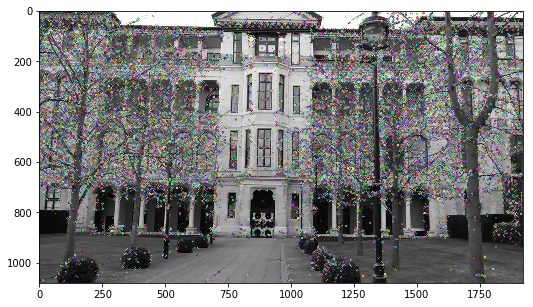

In [1]:
%matplotlib inline  
import cv2
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
from imageio import imread
import pickle

from __future__ import print_function
from joblib import Parallel, delayed


# img1 = cv2.imread('/Users/animesh/Downloads/the-view-from-the-top.jpg')
# img2 = cv2.imread('/Users/animesh/Downloads/west-faade-of-notre-dame-michal-osmenda-wikimedia-commons-1024x680.jpg')

img1 = cv2.imread('/Users/animesh/Downloads/frame00001.png')
img2 = cv2.imread('/Users/animesh/Downloads/frame00023.png')

gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1,None)
kp2, des2 = sift.detectAndCompute(gray2,None)

viz_sift=cv2.drawKeypoints(gray1,kp1, None)

plt.figure(figsize=(10,5))
plt.imshow(viz_sift)

## Perform FLANN-based feature matching

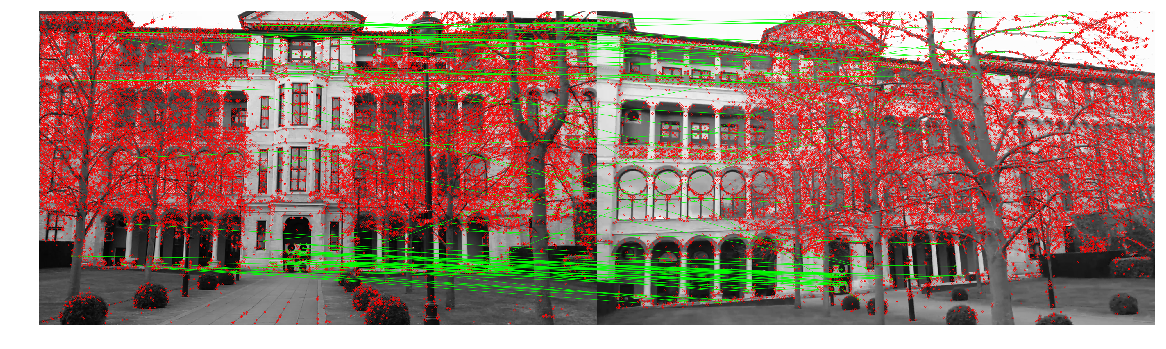

In [2]:
# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

viz_matches = cv2.drawMatchesKnn(gray1,kp1,gray2,kp2,matches,None,**draw_params)

plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(viz_matches)
plt.show()

In [ ]:
'''
Verifying indices of feature points
'''

img1 = imread('/Users/animesh/Downloads/the-view-from-the-top.jpg')
img2 = imread('/Users/animesh/Downloads/west-faade-of-notre-dame-michal-osmenda-wikimedia-commons-1024x680.jpg')

gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)


for i, match in enumerate(matches):
    if matchesMask[i]==[1,0]:
        print(match[0].queryIdx, match[0].trainIdx)


plt.figure(figsize=(10,10))
implot = plt.imshow(gray1, cmap='gray')
plt.scatter(x=[kp1[452].pt[0]], y=[kp1[452].pt[1]], c='r', s=100)
plt.scatter(x=[kp1[460].pt[0]], y=[kp1[460].pt[1]], c='b', s=100)
plt.scatter(x=[kp1[554].pt[0]], y=[kp1[554].pt[1]], c='g', s=100)
plt.scatter(x=[kp1[669].pt[0]], y=[kp1[669].pt[1]], c='y', s=100)
plt.show()


plt.figure(figsize=(10,10))
implot = plt.imshow(gray2, cmap='gray')
plt.scatter(x=[kp2[1823].pt[0]], y=[kp2[1823].pt[1]], c='r', s=100)
plt.scatter(x=[kp2[3676].pt[0]], y=[kp2[3676].pt[1]], c='b', s=100)
plt.scatter(x=[kp2[2064].pt[0]], y=[kp2[2064].pt[1]], c='g', s=100)
plt.scatter(x=[kp2[3342].pt[0]], y=[kp2[3342].pt[1]], c='y', s=100)
plt.show()

print([kp1[554].pt[0]], [kp1[554].pt[1]])
print([kp2[2064].pt[0]], [kp2[2064].pt[1]])

## Generate and store SIFT matches

In [ ]:
'''
Returns corresponding pixel locations of matches
Ex : ((1,3), (2,4))
'''
def get_sift_matches(loc1, loc2, des1, des2):
    
    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    locs = []
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.65*n.distance:
            idx1 = m.queryIdx
            idx2 = m.trainIdx
            locs.append((loc1[idx1], loc2[idx2])) 
    
    return locs

'''
Returns (key_points, descriptor) for an img
'''
def get_sift_features(img_path):
    img = cv2.imread(os.path.join(dataset_path, img_path))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray,None)
    return kp, des
    
    
class Match():
    def __init__(self, img1_path, img2_path, locs):
        self.img1_path = img1_path
        self.img2_path = img2_path
        self.locs = locs

        
dataset_path = '/Users/animesh/Downloads/geometry_images/KingsCollege/seq1/'

# key_points = {}
# descriptors = {}

##====================== Get SIFT Features for all images ===========================###

# for img_file in tqdm.tqdm(os.listdir(dataset_path)):
#     full_path = os.path.join(dataset_path, img_file)
#     kps, des = get_sift_features(full_path)
    
#     # Extract pixel location from cv2.KeyPoint
#     locs = []
#     for each_key_pt in kps:
#         locs.append((each_key_pt.pt[0], each_key_pt.pt[1]))
        
#     key_points[full_path] = locs
#     descriptors[full_path] = des
    
# pickle.dump(key_points, open("key_points.pkl", "wb")) 
# pickle.dump(descriptors, open("descriptors.pkl", "wb"))  
            

In [ ]:
key_points = pickle.load(open("key_points.pkl", "rb"))
descriptors = pickle.load(open("descriptors.pkl", "rb"))

def worker(path):
    img1_path = path[0]
    img2_path = path[1]
    locs = get_sift_matches(key_points[img1_path], key_points[img2_path], 
                                descriptors[img1_path], descriptors[img2_path])
    print("%s --- %s, %d matches"%(os.path.basename(img1_path), os.path.basename(img2_path), len(locs)))
    return Match(img1_path, img2_path, locs)
    
###====================== Compute matches based on SIFT features ===========================###
all_img_files = list(key_points.keys())
n = len(all_img_files)
paths = [] 
for i in range(n):
    img1_path = all_img_files[i]
    j = i + 1
    while j < n-1:
        img2_path = all_img_files[j]
        paths.append((img1_path, img2_path))
        j += 1
    
    if i >= 10:
        break
print('Loaded %d pairs' % (len(paths)))

# Use all CPUs
matches = Parallel(n_jobs=-1)(delayed(worker)(p) for p in paths)
print('Computed %d matches' % (len(matches)))
pickle.dump(matches, open("matches.pkl", "wb")) 

In [ ]:
'''
Returns a patch of size 64x64 by default centered at center: 
- center : tuple of (x,y)
If center is near the corners, None is returned
'''
def get_crop(img, center, patch_size=64):
    h, w = img.shape[0], img.shape[1]
    y, x = center
    if x + patch_size/2 > h or x - patch_size/2 < 0:
        return None
    if y + patch_size/2 > w or y - patch_size/2 < 0:
        return None
    return img[int(x-patch_size/2):int(x+patch_size/2), int(y-patch_size/2):int(y+patch_size/2),:]

'''
Returns a patch of size 64x64 by default which does not include a given patch centered at center: 
- center_to_avoid : tuple of (x,y)
'''
def get_negative_crop(img, center_to_avoid, patch_size=64):
    h, w = img.shape[0], img.shape[1]
    y, x = center_to_avoid
    y_rand = int(np.random.uniform(patch_size/2, w-patch_size/2))
    x_rand = int(np.random.uniform(patch_size/2, h-patch_size/2))
    
    if x - patch_size/2 <= x_rand <= x + patch_size/2:
        return get_negative_crops(img, center_to_avoid, patch_size)
    if y - patch_size/2 <= y_rand <= y + patch_size/2:
        return get_negative_crops(img, center_to_avoid, patch_size)
    
    return img[int(x_rand-patch_size/2):int(x_rand+patch_size/2), int(y_rand-patch_size/2):int(y_rand+patch_size/2),:] 


img1 = imread('/Users/animesh/Downloads/the-view-from-the-top.jpg')
img2 = imread('/Users/animesh/Downloads/west-faade-of-notre-dame-michal-osmenda-wikimedia-commons-1024x680.jpg')

cropped1 = get_crop(img1, (231.8,63.6), patch_size=64)
cropped2 = get_crop(img2, (549.6,174.5), patch_size=64)

# Negative sample with the above crop
neg_cropped = get_negative_crops(img2, (549.6,174.5), patch_size=64)


plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Patch in image1')
plt.imshow(cropped1)

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Corresponding Patch in image2')
plt.imshow(cropped2)

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('Negative sample in image2')
plt.imshow(neg_cropped)
plt.tight_layout()
plt.show()


In [ ]:
###====================== Clean matches to remove corner SIFT features ===========================###
matches = pickle.load(open("matches.pkl", "rb"))

matches_clean = []
patch_size = 64

for match in tqdm.tqdm(matches):
    img1 = imread(match.img1_path)
    img2 = imread(match.img2_path)
    
    locs_clean = []
    for loc in match.locs:
        h1, w1 = img1.shape[0], img1.shape[1]
        h2, w2 = img2.shape[0], img2.shape[1]
        x1, y1 = loc[0]
        x2, y2 = loc[1]
        
        if x1 + patch_size/2 > h1 or x1 - patch_size/2 < 0:
            continue
        if y1 + patch_size/2 > w1 or y1 - patch_size/2 < 0:
            continue
            
        if x2 + patch_size/2 > h2 or x2 - patch_size/2 < 0:
            continue
        if y2 + patch_size/2 > w2 or y2 - patch_size/2 < 0:
            continue
            
        locs_clean.append((loc[0], loc[1]))
    
    matches_clean.append(Match(match.img1_path, match.img2_path, locs_clean))

pickle.dump(matches_clean, open("matches_clean.pkl", "wb")) 

In [ ]:
import random
import shuffle

# Assume that 'matches' are preprocessed such that there are no corner SIFT features
def generate(matches, batch_size = 10, patch_size = 64, pos_ratio = 0.3):
    
    while 1:
        
        # Placeholders for current iteration
        x1 = np.zeros((10, patch_size, patch_size, 3))
        x2 = np.zeros((10, patch_size, patch_size, 3))
        y = np.zeros(10)
        
        for i in range(batch_size):
            match = random.choice(matches)
            img1 = imread(match.img1_path)
            img2 = imread(match.img2.path)
            x1[i,...] = get_crop(img1, loc[0], patch_size=64)
            
            # Choose negative or positive sample
            p = np.random.uniform(0.0,1.0)
            
            # Positive case
            if p <= pos_ratio:    
                loc = random.choice(match.locs)
                x2[i,...] = get_crop(img2, loc[1], patch_size=64)
                y[i] = 1
            
            # Negative case
            else:   
                x2[i,...] = get_negative_crop(img2, center_to_avoid=loc[1], patch_size=64)
                y[i] = 0
    
        return x1, x2, y
    
    
# Split matches into train and validation
shuffle(matches)
validation_split = 0.05
partition{'train':matches[:int(validation_split*len(matches))],
          'val':matches[int(validation_split*len(matches)):]}

    
# Design model
model = Sequential()
[...] # Architecture
model.compile()

# Each iteration -> 10 matches
# 1000 iterations - > 1000 x 10 = 10,000 matches = 1 epoch
# 100 epochs -> 100 x 1000 x 10 = 10,000 x 100 = 1 million matches

# Generators
training_generator = generate(partition['train'], batch_size = 10, patch_size = 64, pos_ratio = 0.3)
val_generator = generate(partition['val'], batch_size = 10, patch_size = 64, pos_ratio = 0.3)


# Train model on dataset
model.fit_generator(generator = training_generator,
                    steps_per_epoch = 1000,
                    validation_data = val_generator,
                    validation_steps = 1000,
                    epochs=100)
    

## Get ground truth (R and t)

In [ ]:
from pyquaternion import Quaternion

with open('/Users/animesh/Downloads/geometry_images/KingsCollege/dataset_train.txt') as f:
    content = f.readlines()
content = [x.strip() for x in content if x.startswith('seq6/')] 

quaternions = {}
translations = {}

for img_data in content:
    data = img_data.split(' ')
    img_file = data[0]
    print(img_file)
    t = np.array([float(data[1]), float(data[2]), float(data[3])])
    q = np.array([float(data[4]), float(data[5]), float(data[6]), float(data[7])])
    
    quaternions[img_file] = q
    translations[img_file] = t


In [ ]:
def get_relative_pose(q1, q2, t1, t2):
    R1 = Quaternion(q1[0], q1[1], q1[2], q1[3]).rotation_matrix
    R2 = Quaternion(q2[0], q2[1], q2[2], q2[3]).rotation_matrix
    
    R_rel = np.matmul(R1, np.transpose(R2))
    q_rel = Quaternion(matrix=R_rel).elements
    t_rel = t2 - np.matmul(R_rel, t1)
    t_rel = t_rel / np.linalg.norm(t_rel)
    print(q_rel, t_rel)
    return q_rel, t_rel

rel_quaternions = {}
rel_translations = {}

file_names = list(quaternions.keys())
n = len(file_names)
for i in range(n):
    for j in range(i+1, n):
        q1 = quaternions[file_names[i]]
        q2 = quaternions[file_names[j]]
        t1 = translations[file_names[i]]
        t2 = translations[file_names[j]]
        q_rel, t_rel = get_relative_pose(q1, q2, t1, t2)
        rel_quaternions[file_names[i] + ' ' + file_names[j]] = q_rel
        rel_translations[file_names[i] + ' ' + file_names[j]] = t_rel
        
        
pickle.dump(rel_quaternions, open("data/rel_quaternions_test.pkl", "wb"), protocol=2) 
pickle.dump(rel_translations, open("data/rel_translations_test.pkl", "wb"), protocol=2)

In [ ]:
from skimage.transform import resize

# def generate(img_paths, rel_quaternions, rel_translations, batch_size = 32):
    
#     while 1:
        
#         # Placeholders for current iteration
#         x1 = np.zeros((batch_size, 224, 224, 3))
#         x2 = np.zeros((batch_size, 224, 224, 3))
#         y_q = np.zeros((batch_size, 4))
#         y_t = np.zeros((batch_size, 3))
        
#         for i in range(batch_size):
#             img1_path = random.choice(img_paths)
#             img2_path = random.choice(list(img_paths).remove(img1_path))
             
#             img1 = imread(os.path.join(dataset_path, img1_path))
#             img2 = imread(os.path.join(dataset_path, img2_path))
            
#             x1[i, ...] = resize(img1, (224,224))
#             x2[i, ...] = resize(img2, (224, 224))
            
#             y_q[i, :] = rel_quaternions(img1_path + ' ' + img2_path)
#             y_t[i, :] = rel_translations(img1_path + ' ' + img2_pathth) 
    
#         return x1, x2, y


# Mean subtraction
imgs = np.random.rand(10,224,224,3)
# mean1 = np.mean(imgs, axis=0)
# mean2 = np.mean(mean1, axis=0)
# mean3 = np.mean(mean2, axis=0)
# print(mean3)

imgs = np.zeros((261, 224, 224, 3))

for i, img_file in tqdm.tqdm(enumerate(os.listdir(dataset_path))):
    img = imread(os.path.join(dataset_path, img_file))
#     img = resize(img, (224, 224))
#     imgs[i,...] = img*255

# mean1 = np.mean(imgs, axis=0)
# mean2 = np.mean(mean1, axis=0)
# mean3 = np.mean(mean2, axis=0)
print(mean3)

In [ ]:
matches=pickle.load(open("data/matches_clean_2.pkl", "rb"))

matches_clean = []
for match in matches:
    if len(match.locs) > 5:
        matches_clean.append(match)
        
pickle.dump(matches_clean, open("data/matches_clean_2.pkl", "wb"), protocol=2) 






In [ ]:
print(len(matches_clean))


